<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Image/PyShuTu_3Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [319]:
# !pip install opencv-python
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2
import skimage as ski
from tqdm import tqdm
import scipy as sci

In [320]:
# (x,y,z) = (695,435,63)
# fig,ax =plot_point_data(x,y,z,image_stack,rad=250,lw=.5)

In [321]:
""" Helper Plotting"""
def plot_point_data(x,y,z,image_stack,vmin=None,vmax=None,lw=.2,figsize=(3,2.7),cmap='gray',rad=None):
    # () = xyz

    if rad is not None:
        min_x = np.max([x-rad,0])
        max_x = np.min([x+rad,image_stack.shape[0]])
        min_y = np.max([y-rad,0])
        max_y = np.min([y+rad,image_stack.shape[1]])
        image_stack = image_stack[min_y:max_y,min_x:max_x,:]
        x=rad
        y=rad

    fig,ax=plt.subplots(2,2,width_ratios=[5, 1],height_ratios=(5,1),figsize=figsize,dpi=300)
    ax[1,1].axis('off')

    ax[0,0].imshow(image_stack[:,:,z],aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap,zorder=-1)
    ax[0,0].axvline(x,color='m',linewidth=lw)
    ax[0,0].axhline(y,color='c',linewidth=lw)

    collapse_x = image_stack[y,:,:].T
    ax[1,0].imshow(collapse_x,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap,zorder=-1)
    ax[1,0].axhline(z,color='y',linewidth=lw)
    ax[1,0].axvline(x,color='m',linewidth=lw)

    collapse_y =image_stack[:,x,:]
    print(collapse_y.shape)
    ax[0,1].imshow(collapse_y,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap,zorder=-1)
    ax[0,1].axvline(z,color='y',linewidth=lw)
    ax[0,1].axhline(y,color='c',linewidth=lw)

    return fig,ax

def uint8_invert(image):
    return ((-1*(image.astype(float)-127.5)) + 127.5).astype("uint8")

In [322]:
""" Load Pilot Image"""
image_set_dir = "C:\\Users\\dennis.tabuena\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\CA1\\"
image_tag = 'Overlay'
os.chdir(image_set_dir)
tif_list=list()
for dir,root,files in os.walk(image_set_dir):
    for f in files:
        if image_tag in f:
            tif_list.append(os.path.join(dir,f))
pd_dict = {'file_loc': [t for t in tif_list],
           'z': [t.split("_")[-2] for t in tif_list]}
image_df = pd.DataFrame(pd_dict)
"""Build Stack"""
image_stack = list()
for path in tqdm( image_df['file_loc'] ):
    image_data =cv2.imread(path)
    image_data = image_data[:,:,1]
    image_stack.append(image_data)
image_stack=np.stack(image_stack,axis=-1)
# print(image_stack.shape)


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [00:16<00:00, 10.32it/s]


In [339]:
def build_filter_vec_set(filter_params,top=np.pi):
    """ build a list of filters at different angles (thetas) """
    theta_list = np.arange(0,1,1/filter_params['n_kernel']) * top
    filter_list = list()
    for theta in theta_list:
        filter = -np.real(ski.filters.gabor_kernel(filter_params['spatial_freq'],
                                                    theta,
                                                    sigma_x=filter_params['radius'],
                                                    sigma_y=filter_params['len'],
                                                    n_stds=filter_params['n_stdevs'],))
        filter_list.append(filter)
    filter_list = normalize_filters(filter_list)
    filter_list = square_filters(filter_list)
    vectors = rad_2_vec(theta_list)
    filter_set = {'filter_list':filter_list,'vectors':vectors}
    return filter_set

def square_filters(filter_list):
    """ pad all filters to squares of the same size"""
    dims = np.array([f.shape for f in filter_list])
    max_d =  np.max(dims)
    for i,filter in enumerate(filter_list):
        f_dim = filter.shape
        delta = max_d-f_dim
        half_delta = (delta/2).astype(int)
        padded= np.pad(filter,((half_delta[0],half_delta[0]),
                               (half_delta[1],half_delta[1]),))
        filter_list[i] = padded
    return filter_list

def normalize_filters(filter_list):
    """ scale filters to maximum (0:1) """
    dims = np.array([(np.min(x),np.max(x)) for x in filter_list])
    scalar = 1 / np.max(np.abs(dims))
    filter_list = [x*scalar for x in filter_list]
    return filter_list

def rad_2_vec(angles):
    return [{'x':np.cos(a),'y':np.sin(a)} for a in angles]

def even_axs(n):
    rt_n = np.sqrt(n)
    y=int(np.floor(rt_n))
    x = int(np.ceil(n/y))
    return (x,y)





# (fx,fy) = even_axs(filter_params['n_kernel'])
# fig, ax = plt.subplots(fy,fx,figsize=(fx,fy),dpi=100)
# ax = ax.flatten()
# for i,f in enumerate(filter_set['filter_list']):
#     cbh = ax[i].imshow(f,cmap='coolwarm',vmin=-1,vmax=1)
#     plt.colorbar(cbh)
#     title_str = str(np.round(filter_set['vectors'][i]['x'],2)) +' : '+ \
#                 str(np.round(filter_set['vectors'][i]['y'],2))
#     ax[i].set_title(title_str)
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])
# plt.tight_layout()

In [343]:
sample_stack = image_stack[490:960,860:1440,:]

In [344]:
def min_project(image_stack,dim=2):
    projection = np.min(image_stack.astype('float16'),dim).astype(float)
    projection = (projection - np.min(projection)) / (np.max(projection) - np.min(projection))
    return projection

def background_sub(image,sigma):
    background = sci.ndimage.gaussian_filter(image,sigma=sigma)
    # fig,ax=plt.subplots(1,2,figsize=(2,1),dpi=300)
    # ax[0].imshow(background,cmap='gray')
    # ax[0].set_xlim(xlims)
    # ax[0].set_ylim(ylims)
    # ax[0].set_title('background')
    # _=ax[1].hist(image.flatten())
    subtracted = image.astype('float16')-background
    subtracted = (subtracted-np.min(subtracted.flatten())) / (np.max(subtracted.flatten()) - np.min(subtracted.flatten()))
    return subtracted


# # print(image_stack.shape)

# projection = min_project(sample_stack)
# fig,ax=plt.subplots(1,2,figsize=(2,1),dpi=300)
# ax[0].imshow(projection,cmap='gray')
# ax[0].set_title('proj')
# _=ax[1].hist(projection.flatten())





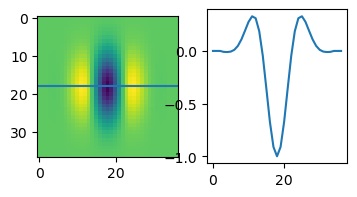

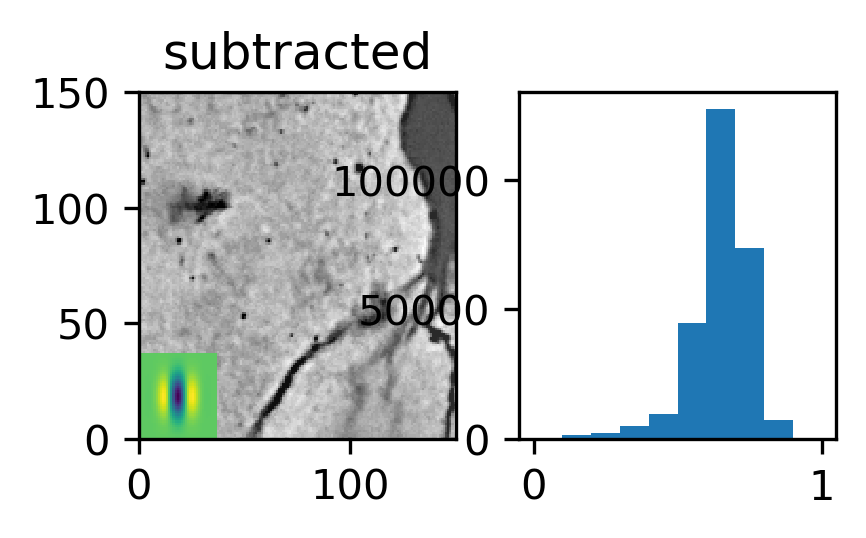

In [345]:

rad = 5
filter_params = {'radius': rad, 'len': 6, 'n_kernel': 7,
                 'spatial_freq': .1/rad*3 , 'n_stdevs': 3}


filter_set = build_filter_vec_set(filter_params)
filter = filter_set['filter_list'][0]

fig,ax=plt.subplots(1,2,figsize=(4,2),dpi=100)
half_dim = int(filter.shape[0]/2)
cbh = ax[0].imshow(filter)
ax[0].axhline(half_dim)
ax[1].plot(filter[half_dim,:])

subtracted = background_sub(sample_stack[:,:,50],sigma=32)
fig,ax=plt.subplots(1,2,figsize=(3,1.5),dpi=300)
ax[0].pcolormesh(subtracted[150:300,150:300],cmap='gray')
ax[0].set_title('subtracted')
_=ax[1].hist(subtracted.flatten())
ax[0].pcolormesh(filter)


In [346]:
def convolve_plane(image_plane,filter_set):
    conv_list = list()
    for filter in filter_set['filter_list']:
        filter_result = sci.signal.convolve2d(image_plane,
                                              filter,
                                              mode='same',
                                              boundary='symm')
        conv_list.append(filter_result)
    filter_results = np.stack(conv_list,axis=-1)
    return filter_results


def convolve_zstack(image_stack,filter_set):
    num_z = image_stack.shape[2]
    stack_conve_results = np.zeros( image_stack.shape + (len(filter_set['filter_list']),) ,'float16')
    for zi in tqdm( range(image_stack.shape[-1]) ):
        filter_results = convolve_plane(image_stack[:,:,zi], filter_set)
        stack_conve_results[:,:,zi,:] = filter_results
    return stack_conve_results

    # z_list = [image_stack[:,:,z] for z in range(image_stack.shape[-1])]
    # for z_plane in tqdm( z_list ):
    #     filter_results = convolve_plane(z_plane,filter_set)
    #     stack_conv_list.append(filter_results)
    # full_filter_results=np.stack(stack_conv_list,axis=-1)
    # return full_filter_results



conv_results = convolve_zstack(sample_stack,filter_set)
conv_results.shape


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [17:59<00:00,  6.28s/it]


(470, 580, 172, 7)

In [347]:
def norm_01(data):
    return (data-np.min(data)) / (np.max(data)-np.min(data))


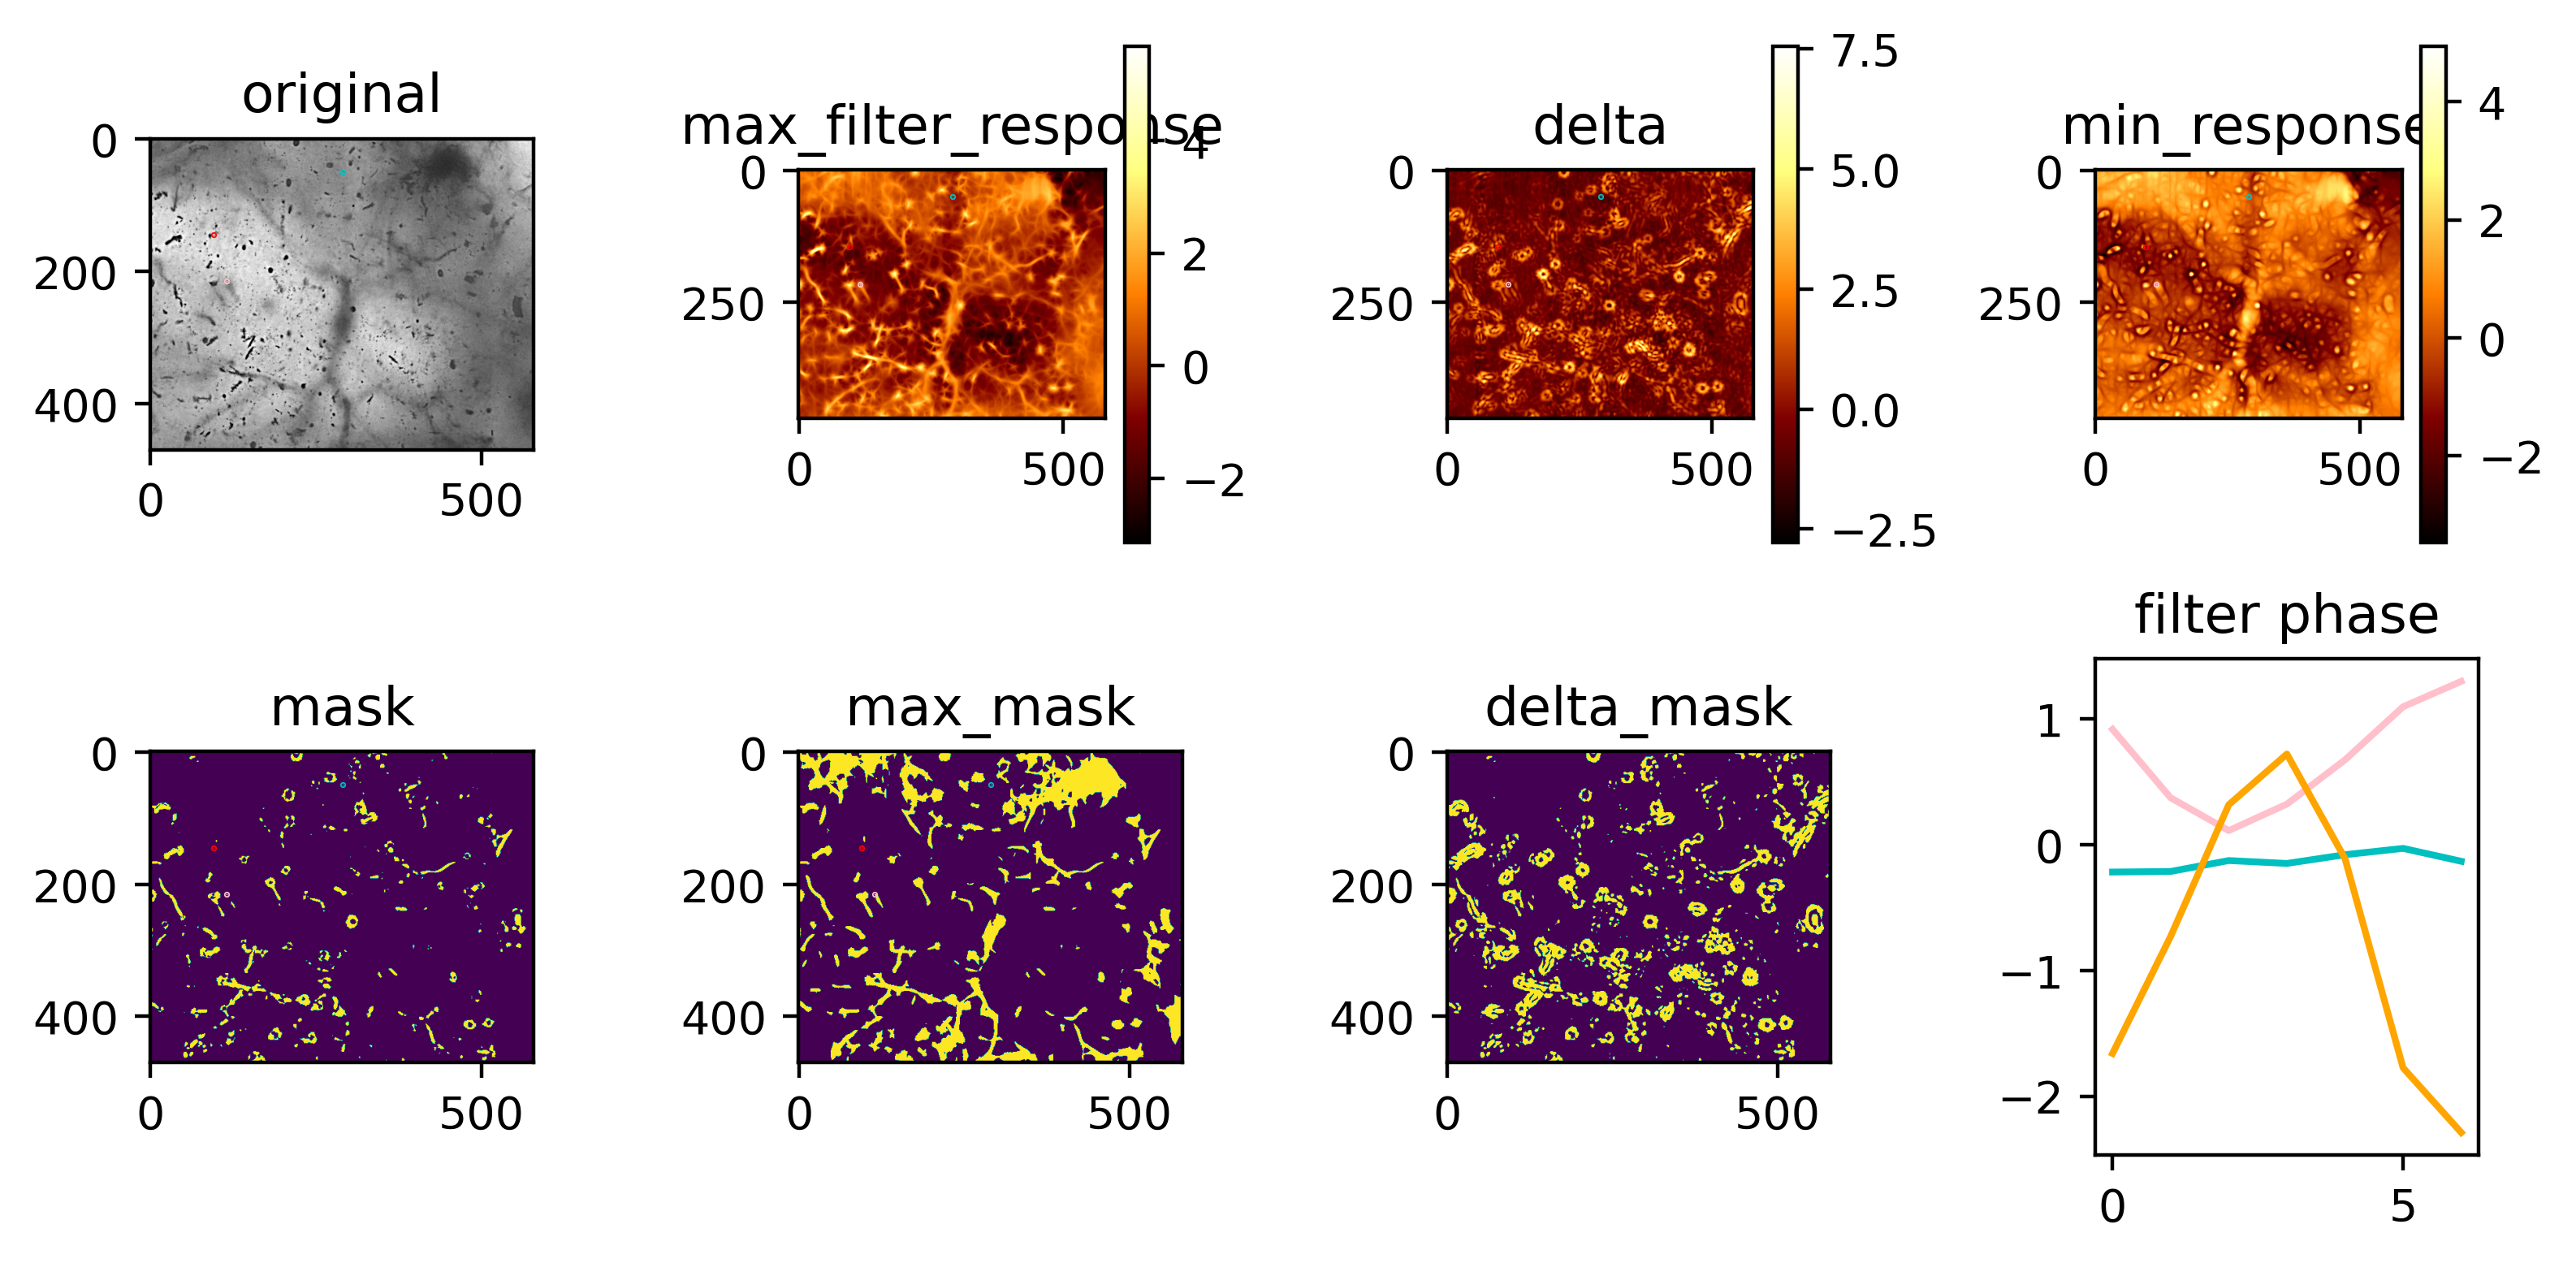

In [348]:
def conv_to_mask(conv_results,orig,thresh,to_plot=False):
    conv_results = sci.stats.zscore(norm_01(conv_results))
    max_ind = np.argmax(conv_results,axis=-1)
    max_response = sci.stats.zscore(np.max(conv_results,axis=-1))
    min_ind = np.argmin(conv_results,axis=-1)
    min_response = sci.stats.zscore(np.min(conv_results,axis=-1))
    delta = sci.stats.zscore(max_response - min_response)

    max_mask= max_response>thresh['max']
    delta_mask = delta>thresh['d']

    mask = np.logical_and(delta_mask,max_mask)



    if to_plot:
        fig,ax=plt.subplots(2,4,figsize=(8,4),dpi=400)
        ax = ax.flatten()

        ax[0].imshow(orig,cmap='gray')
        ax[0].set_title('original')

        cbh1 = ax[1].imshow(max_response,cmap='afmhot')
        ax[1].set_title('max_filter_response')
        plt.colorbar(cbh1)

        cbh2 = ax[2].imshow(delta,cmap='afmhot')
        ax[2].set_title('delta')
        plt.colorbar(cbh2)


        cbh3 = ax[3].imshow(min_response,cmap='afmhot')
        ax[3].set_title('min_response')
        plt.colorbar(cbh3)

        (d1,d2) = (290,50)
        (d3,d4) = (115,215)
        (d5,d6) = (95,145)
        for a in ax[0:6]:
            a.scatter(d3,d4,s=.1,color='pink')
            a.scatter(d1,d2,s=.1,color='c')
            a.scatter(d5,d6,s=.1,color='red')
        ax[7].set_title('filter phase')
        ax[7].plot(conv_results[d2,d1,:],color='c')
        ax[7].plot(conv_results[d4,d3,:],color='pink')
        ax[7].plot(conv_results[d6,d5,:],color='orange')


        ax[5].imshow(max_mask)
        ax[5].set_title('max_mask')


        ax[6].imshow(delta_mask)
        ax[6].set_title('delta_mask')

        ax[4].imshow(mask)
        ax[4].set_title('mask')

        plt.tight_layout()
    return mask




    # ax[5].hist2d(max_response.flatten(),delta.flatten(),bins=40)
    # ax[5].set_ylabel('delta')
    # ax[5].set_xlabel('max')





    # fig,ax = plt.subplots(1)





thresh = {'d':1,'max':1}

# mask = conv_to_mask(conv_results,sample_stack,thresh=thresh)
mask = conv_to_mask(conv_results[:,:,25,:],sample_stack[:,:,25],thresh=thresh,to_plot=True)
# mask = conv_to_mask(conv_results[:,:,:,:],sample_stack[:,:,50],thresh=thresh,to_plot=False)

In [335]:
labeled_mask,num_labels = ski.measure.label(mask,return_num=True)
sizes,edges = np.histogram(labeled_mask.flatten(),bins=np.arange(0,num_labels+2))
labels = edges[1:-1]
sizes = sizes[1:]
to_small = labels[sizes<500]

for l in to_small:
    labeled_mask[labeled_mask==l] = 0
labeled_mask,num_labels = ski.measure.label(labeled_mask>0,return_num=True)
sizes,edges = np.histogram(labeled_mask.flatten(),bins=np.arange(0,num_labels+2))
labels = edges[1:-1]
sizes = sizes[1:]
print(num_labels)

# print(counts)
# print(edges)
# print(num_labels)






main_label = labels[np.where(sizes==np.max(sizes))[0][0]]
main_item = labeled_mask == main_label
plt.imshow(main_item[:,:,50])
tifffile.imwrite('./main_item.tiff', main_item*1)

3


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
print(sample_stack.shape,main_item.shape)

In [ ]:
hilighted = np.stack([sample_stack,sample_stack,sample_stack])
hilighted[0,:,:,:] = hilighted[0,:,:,:] + main_item*.4*255

hilighted_wrt = hilighted.transpose([3,1,2,0])*1
print(hilighted_wrt.shape)
tifffile.imwrite('./hilighted.tiff', hilighted_wrt.astype('uint8'),metadata={'axes': 'ZYXC'})

In [ ]:
# distance = sci.ndimage.distance_transform_edt(main_item)
# plt.imshow(distance[:,:,50])

In [ ]:
# segments = ski.segmentation.watershed(-distance,mask=main_item)
# plt.imshow(segments[:,:,50])
